CNN

In [6]:
!pip install torch==1.10.0+cu118 torchvision==0.11.1+cu118 -f https://download.pytorch.org/whl/cu118/torch_stable.html


Looking in links: https://download.pytorch.org/whl/cu118/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.10.0+cu118 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.0+cu118, 2.0.1, 2.0.1+cu118, 2.1.0, 2.1.0+cu118, 2.1.1, 2.1.1+cu118, 2.1.2, 2.1.2+cu118, 2.2.0, 2.2.0+cu118, 2.2.1, 2.2.1+cu118, 2.2.2, 2.2.2+cu118)
ERROR: No matching distribution found for torch==1.10.0+cu118


Files already downloaded and verified
データの数: 10000


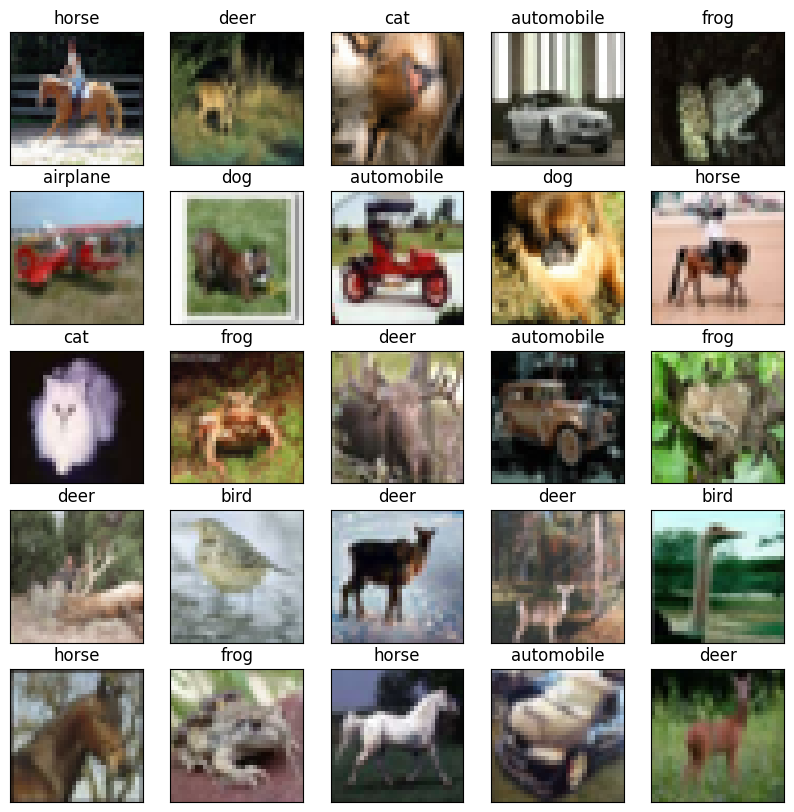

In [3]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

cifar10_data = CIFAR10(root="./data",
                       train=False,download=True,
                       transform=transforms.ToTensor())
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]


print("データの数:", len(cifar10_data))

n_image = 25  #表示数
cifar10_loader = DataLoader(cifar10_data, batch_size=n_image, shuffle=True)
dataiter = iter(cifar10_loader)  # イテレータ:データに順番にアクセスする
#images, labels = dataiter.next()  # 最初のバッチを取り出す
images, labels = next(iter(cifar10_loader))

plt.figure(figsize=(10,10))  # 画像サイズ
for i in range(n_image):
    ax = plt.subplot(5,5,i+1)
    ax.imshow(images[i].permute(1, 2, 0))
    label = cifar10_classes[labels[i]]
    ax.set_title(label)
    ax.get_xaxis().set_visible(False)  # 軸非表示
    ax.get_yaxis().set_visible(False)

plt.show()

Files already downloaded and verified


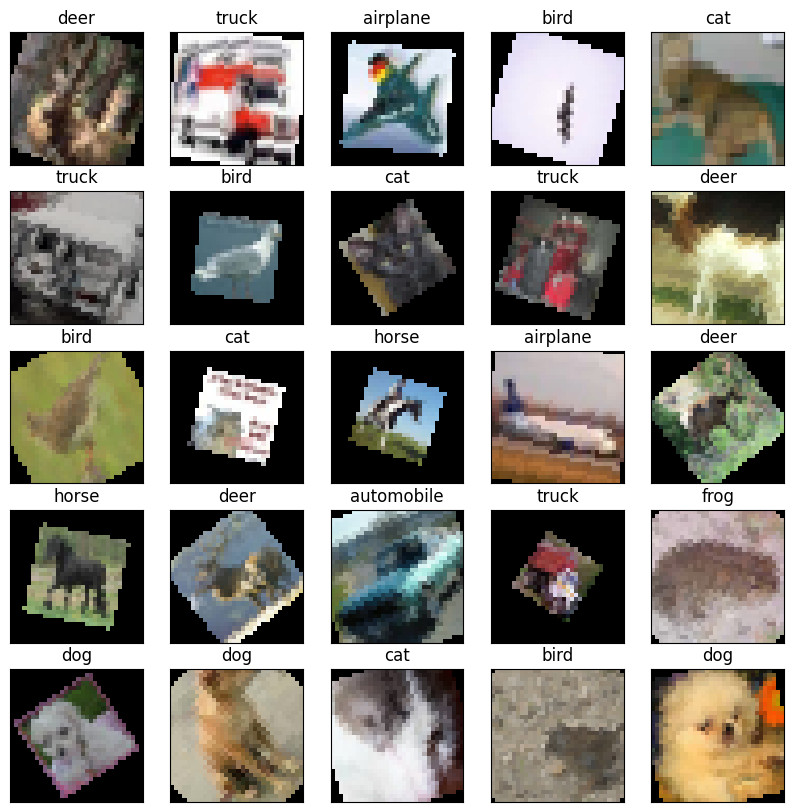

In [5]:
transform = transforms.Compose([transforms.RandomAffine((-45, 45), scale=(0.5, 1.5)),  # 回転,リサイズ
                                transforms.ToTensor()])
cifar10_data = CIFAR10(root="./data",
                       train=False,download=True,
                       transform=transform)

cifar10_loader = DataLoader(cifar10_data, batch_size=n_image, shuffle=True)
dataiter = iter(cifar10_loader)
#images, labels = dataiter.next()
images, labels = next(iter(cifar10_loader))

plt.figure(figsize=(10,10))  # 画像の表示サイズ
for i in range(n_image):
    ax = plt.subplot(5,5,i+1)
    ax.imshow(images[i].permute(1, 2, 0))
    label = cifar10_classes[labels[i]]
    ax.set_title(label)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [6]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

affine = transforms.RandomAffine((-30, 30), scale=(0.8, 1.2))  # 回転,リサイズ
flip = transforms.RandomHorizontalFlip(p=0.5)  # 左右反転
normalize = transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))  # 平均値を0、標準偏差を1に
to_tensor = transforms.ToTensor()

transform_train = transforms.Compose([affine, flip, to_tensor, normalize])
transform_test = transforms.Compose([to_tensor, normalize])

cifar10_train = CIFAR10("./data", train=True, download=True, transform=transform_train)
cifar10_test = CIFAR10("./data", train=False, download=True, transform=transform_test)

# DataLoaderの設定
batch_size = 64
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
import torch.nn as nn

class Net(nn.Module):#モデル構築
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)  # 畳み込み層:(入力チャンネル数, フィルタ数、フィルタサイズ)
        self.relu = nn.ReLU()  # ReLU
        self.pool = nn.MaxPool2d(2, 2)  # プーリング層:（領域のサイズ, 領域の間隔）
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 256)  # 全結合層
        self.dropout = nn.Dropout(p=0.5)  # ドロップアウト:(p=ドロップアウト率)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16*5*5)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

net = Net()
#net.cuda()  # GPU対応
print(net)

Net(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [11]:
from torch import optim

# 交差エントロピー誤差関数
loss_fnc = nn.CrossEntropyLoss()

# 最適化アルゴリズム
optimizer = optim.Adam(net.parameters())

# 損失のログ
record_loss_train = []
record_loss_test = []

# 学習
for i in range(20):  # 20エポック学習
    net.train()  # 訓練モード
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # ミニバッチ（x, t）を取り出す

        y = net(x)
        loss = loss_fnc(y, t)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    net.eval()  # 評価モード
    loss_test = 0
    for j, (x, t) in enumerate(test_loader):  # ミニバッチ（x, t）を取り出す

        y = net(x)
        loss = loss_fnc(y, t)
        loss_test += loss.item()
    loss_test /= j+1
    record_loss_test.append(loss_test)

    if i%1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)

Epoch: 0 Loss_Train: 1.6299141081397797 Loss_Test: 1.4491279922473204
Epoch: 1 Loss_Train: 1.555998879015598 Loss_Test: 1.4060624010243994
Epoch: 2 Loss_Train: 1.5052403893007342 Loss_Test: 1.3794259235357782
Epoch: 3 Loss_Train: 1.4743316374776307 Loss_Test: 1.319137078941248
Epoch: 4 Loss_Train: 1.444812335474107 Loss_Test: 1.275669379219128
Epoch: 5 Loss_Train: 1.4170505232213404 Loss_Test: 1.2664409541780022
Epoch: 6 Loss_Train: 1.396775316551823 Loss_Test: 1.258594462066699
Epoch: 7 Loss_Train: 1.3842888053725748 Loss_Test: 1.2391505898184079
Epoch: 8 Loss_Train: 1.365288481535509 Loss_Test: 1.2418389411488915
Epoch: 9 Loss_Train: 1.3589473848452653 Loss_Test: 1.1977988565044038
Epoch: 10 Loss_Train: 1.3427295273984485 Loss_Test: 1.1948245509414916
Epoch: 11 Loss_Train: 1.3322543648197829 Loss_Test: 1.1903708505023056
Epoch: 12 Loss_Train: 1.3174159728047792 Loss_Test: 1.163987526848058
Epoch: 13 Loss_Train: 1.312555075149097 Loss_Test: 1.1445912399869056
Epoch: 14 Loss_Train: 1.3

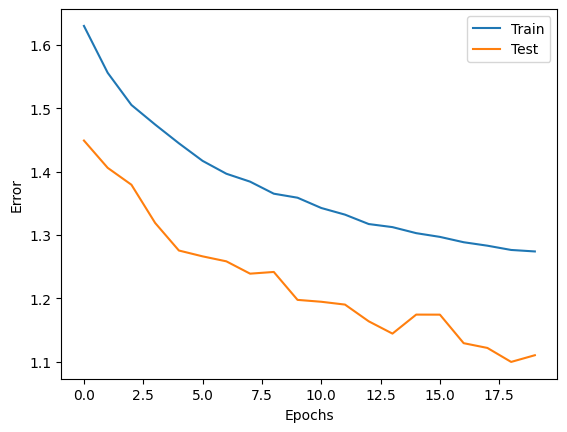

In [12]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

In [14]:
correct = 0
total = 0
net.eval()  # 評価モード
for i, (x, t) in enumerate(test_loader):

    y = net(x)
    correct += (y.argmax(1) == t).sum().item()
    total += len(x)
print("正解率:", str(correct/total*100) + "%")

正解率: 61.09%


In [15]:
import torch
torch.save(net, "model.pth")